# Fluxonium CZ gate tutorial

B. McDonough

This notebook provides a tutorial for using scQubits to simulate the procedure for effectuating a CZ-gate on a coupled pair of fluxonium qubits described by Nesterov et Al in [Microwave-Activated Controlled-Z Gate for Fixed-Frequency Fluxonium Qubits.](https://arxiv.org/abs/1802.03095) For more information about simulating driven circuits with scQubits, see the previous tutorial, "Driven composite systems and interface with QuTiP."

Capacitive coupling of two fluxonium qubits $A$ and $B$ results in a coupling term $J_C \hat n_A \hat n_B$ being added to the Hamiltonian. This coupling shifts the energy levels so that the $\omega_{01\to 02}$ transition frequency is detuned from the $\omega_{11 \to 12}$ transition frequency. This allows the $\ket{11} \to \ket{12}$ transition to be driven without causing leakage from other states in the computational space. A cross-resonance drive on both qubits can be used to eliminate the coupling of the drive to qubit $A$, so that the form of an on-resonance drive term added to the Hamiltonian becomes $f(t)\cos(\omega_d t)\hat n_B$.

Driving the $\ket{11}\to\ket{12}$ transition for a full period results in the $\ket{11}$ state aquiring a phase of $e^{i\pi}=-1$, without affecting the other states in the computational subspace. This results in the application of $CZ = \operatorname{diag}(1,1,1,-1)$ up to phases which can be eliminated by instant single-qubit $Z$ gates.

In [1448]:
import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt
from itertools import product
from qutip.qip.operations import rz, cz_gate

#experimental values borrowed from 
#[https://arxiv.org/abs/1802.03095]
qbta = scq.Fluxonium(
    EC = 1.5,
    EJ = 5.5,
    EL = 1.0,
    flux = .5, #flux frustration point
    cutoff = 110,
    truncated_dim = 10
)

qbtb = scq.Fluxonium(
    EC = 1.2,
    EJ = 5.7,
    EL = 1.0,
    flux = .5,
    cutoff = 110,
    truncated_dim = 10
)

hilbertspace = scq.HilbertSpace([qbta, qbtb])

hilbertspace.add_interaction(
    g_strength = .15,
    op1 = qbta.n_operator,
    op2 = qbtb.n_operator,
    add_hc = True
)

hilbertspace.generate_lookup()

## Drive simulation functions
These functions are taken from the previous tutorial, "Driven composite systems and interface with QuTiP."

In [1450]:
#get the index of a dressed state closed to a subsystem product state
def dressed_index(hilbertspace, *states):
    states_by_index = list(sorted([(hilbertspace.get_subsys_index(sys), state) for (sys, state) in states]))
    return hilbertspace.dressed_index(list(zip(*states_by_index))[1])[0]

#wrap operator in identities and change to dressed eigenbasis
def basis_change(operator, subsystem, hilbertspace, dressed_eigenbasis = True):
    bare_evecs, = hilbertspace.bare_eigenstates(subsystem)
    op_id_wrap = scq.identity_wrap(operator, subsystem, hilbertspace.subsys_list, evecs = bare_evecs)
    evecs, = hilbertspace["evecs"]
    return op_id_wrap.transform(evecs)

total_truncation = 20 #set simulation truncation level

#truncate operators to desdired dimension
def truncate(operator):
    return qt.Qobj(operator[:total_truncation, : total_truncation])

#get the transition frequency between two states specified by dressed indices
def transition_frequency(s0, s1):
    return hilbertspace.energy_by_dressed_index(s1)-hilbertspace.energy_by_dressed_index(s0)

## States and operators 
Get the matrix representations of the drive operators in the dressed eigenbasis

In [1452]:
#charge operator for qubit b
n_b = basis_change(qbtb.n_operator(), qbta, hilbertspace)
n_b = truncate(n_b) 

In [1453]:
#convert the product states to the closes eigenstates of the dressed system
product_states = [(0,0),(0,1),(1,0),(1,1),(1,2)]
idxs = [dressed_index(hilbertspace, (qbta, s1),(qbtb, s2)) for (s1,s2) in product_states]
states = [qt.basis(total_truncation, idx) for idx in idxs]

#The computational subspace is spanned by the first 4 states
computational_subspace = states[:4]

In [1455]:
w1112 = transition_frequency(idxs[3], idxs[4])

#Gaussian pulse
A = .014
tg = 500
def drive_coeff(t, args):
    return A*np.exp(-8*t*(t-tg)/tg**2)*np.cos(w1112*t)

#Hamiltonian in dressed eigenbasis
evals, = hilbertspace["evals"]
diag_dressed_hamiltonian = qt.Qobj(np.diag(evals), dims = [hilbertspace.subsystem_dims]*2)
diag_dressed_hamiltonian_trunc = truncate(diag_dressed_hamiltonian)

#time-dependent drive Hamiltonian
H_qbt_drive = [
    diag_dressed_hamiltonian_trunc,
    [n_b, drive_coeff] #driving through the resonator
]

## Simulation

Text(0.5, 0, 't (ns)')

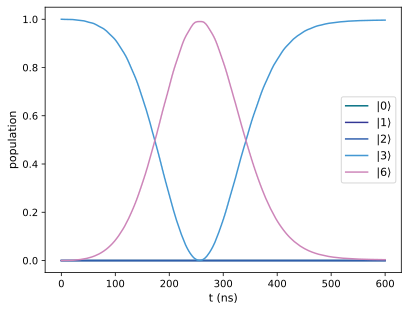

In [1462]:
tlist = np.linspace(0, 600, 600) #total time

#This simulation is just for viewing the affect of the pulse
result = qt.sesolve(H_qbt_drive, qt.basis(20,3), tlist, e_ops = [state*state.dag() for state in states])

for idx,res in zip(idxs, result.expect):
    plt.plot(tlist, res, label = r"$|%u\rangle$"%(idx))
plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)")

## Propagator calculation

In [1435]:
prop = qt.propagator(H_qbt_drive, tlist)[-1] #get the propagator at the final time step
#truncate the propagator to just the computational subspace
Uc = qt.Qobj([[prop.matrix_element(s1, s2) for s1 in computational_subspace] for s2 in computational_subspace])

In [1463]:
#Factor global phase so that upper-left corner of matrix is unity
def remove_global_phase(op):
    elem = op.data.toarray()[0][0]
    return op*np.conj(elem)

#Compute the phase differences to remove from the result using single-qubit Z-gates
def dphi(state):
    return -np.angle(prop.matrix_element(state, state))+np.angle(prop.matrix_element(states[0],states[0]))

In [1464]:
#product of single-qubit Z-gates
Uz = remove_global_phase(qt.tensor(rz(dphi(states[2])), rz(dphi(states[1]))))

In [1439]:
Uc_reshaped = qt.Qobj(Uc.data, dims = [[2,2],[2,2]])
Ucprime = remove_global_phase(Uc_reshaped*Uz)
Ucprime

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 9.99999118e-01+0.00000000e+00j -2.48462069e-09-4.79136300e-07j
  -6.99140034e-06+4.24988749e-05j -1.41140125e-07+1.31809343e-07j]
 [ 2.51872021e-09-4.79256819e-07j  9.99997718e-01+0.00000000e+00j
   1.75319619e-06+3.15000494e-08j -7.11620187e-06-5.40373028e-05j]
 [ 6.98641123e-06+4.25459957e-05j -8.74064008e-07+1.59877812e-08j
   9.99902549e-01+0.00000000e+00j  1.50711775e-08+4.85864885e-07j]
 [-1.74168843e-08-9.48896012e-09j -9.90466051e-06+5.37049387e-05j
   3.82252367e-08-4.84907310e-07j -9.96961064e-01-4.93184143e-02j]]

In [1440]:
qt.metrics.process_fidelity(Ucprime, cz_gate())

(0.9968417324797422+0.03685678182936908j)